In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [3]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
942,00004902_000.png,No Finding,0,4902,054Y,M,PA,2021,2021,0.194311,0.194311
874,00004604_001.png,No Finding,1,4604,055Y,F,AP,2500,2048,0.171000,0.171000
1310,00006875_016.png,No Finding,16,6875,055Y,F,AP,2500,2048,0.168000,0.168000


## EDA

### The patient demographic data such as gender, age, patient position,etc. (as it is available)

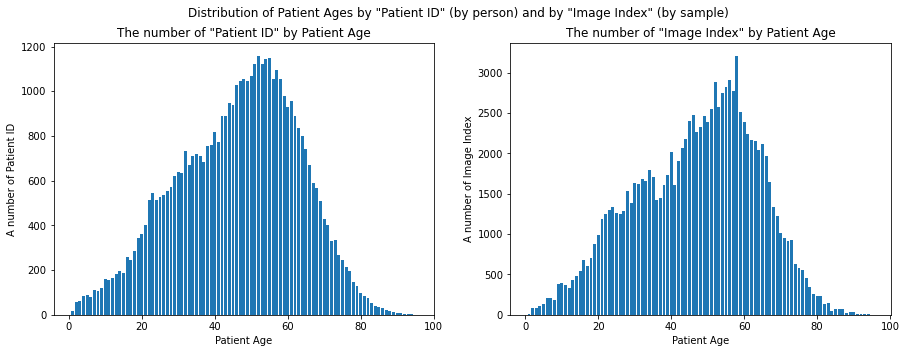

Describe something here



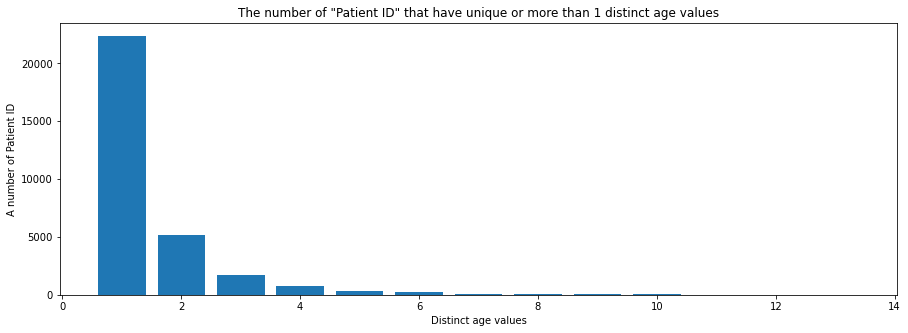

Describe something here



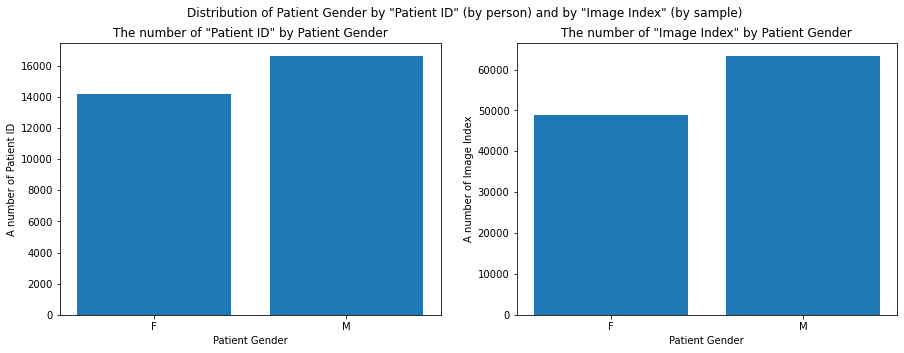

Describe something here



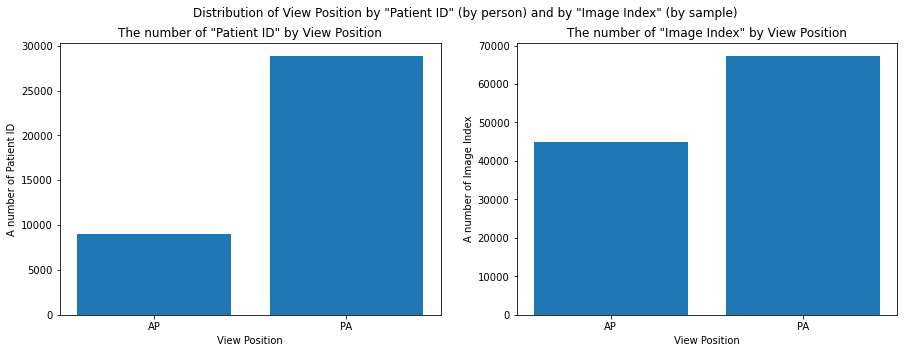

Describe something here



In [82]:
# prepare demographics (filter out unreasonable data e.g. age <=0 or >120)
def plot_bar(ax, x, height, data, title, xlab, ylab):
    ax.bar(x = x, height = height, data = data)
    ax.set_title(title)
    ax.set(xlabel = xlab, ylabel= ylab)
demographic = all_xray_df[['Image Index', 'Patient ID', 'Patient Age', 'Patient Gender', 'View Position']]
demographic = demographic[(demographic['Patient Age'] > 0) &  (demographic['Patient Age'] <= 120)]

    
# plot Distribution of Patient Ages by "Patient ID" (by person) and by "Image Index" (by sample)
patient_age = demographic.groupby('Patient Age')[['Image Index', 'Patient ID']].nunique().reset_index()
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))    
plot_bar(ax1, x = 'Patient Age', height = 'Patient ID', data = patient_age, 
         title = 'The number of "Patient ID" by Patient Age',  
         xlab = 'Patient Age', ylab = 'The number of Patient ID')
plot_bar(ax2, x = 'Patient Age', height =  'Image Index', data = patient_age, 
         title = 'The number of "Image Index" by Patient Age', 
         xlab = 'Patient Age', ylab = 'The number of Image Index')
fig.suptitle('Distribution of Patient Ages by "Patient ID" (by person) and by "Image Index" (by sample)')
plt.show()
print('Describe something here')
print('')

# plot 'The number of "Patient ID" that have unique or more than 1 distinct age values
patient_multiage = demographic.groupby('Patient ID')[['Patient Age']].nunique().reset_index()
patient_multiage = patient_multiage.groupby('Patient Age')[['Patient ID']].count().reset_index()
fig, ax = plt.subplots(figsize=(15,5))
plot_bar(ax, x = 'Patient Age', height =  'Patient ID', data = patient_multiage, 
         title = 'The number of "Patient ID" that have unique or more than 1 distinct age values', 
         xlab = 'Distinct age values', ylab = 'The number of Patient ID')
plt.show()
print('Describe something here')
print('')

# gender
gender = demographic.groupby('Patient Gender')[['Image Index', 'Patient ID']].nunique().reset_index()
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))    
plot_bar(ax1, x = 'Patient Gender', height = 'Patient ID', data = gender, 
         title = 'The number of "Patient ID" by Patient Gender',  
         xlab = 'Patient Gender', ylab = 'A number of Patient ID')
plot_bar(ax2, x = 'Patient Gender', height =  'Image Index', data = gender, 
         title = 'The number of "Image Index" by Patient Gender', 
         xlab = 'Patient Gender', ylab = 'The number of Image Index')
fig.suptitle('Distribution of Patient Gender by "Patient ID" (by person) and by "Image Index" (by sample)')
plt.show()
print('Describe something here')
print('')

# patient position
position = demographic.groupby('View Position')[['Image Index', 'Patient ID']].nunique().reset_index()
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))    
plot_bar(ax1, x = 'View Position', height = 'Patient ID', data = position, 
         title = 'The number of "Patient ID" by View Position',  
         xlab = 'View Position', ylab = 'The number of Patient ID')
plot_bar(ax2, x = 'View Position', height =  'Image Index', data = position, 
         title = 'The number of "Image Index" by View Position', 
         xlab = 'View Position', ylab = 'The number of Image Index')
fig.suptitle('Distribution of View Position by "Patient ID" (by person) and by "Image Index" (by sample)')
plt.show()
print('Describe something here')
print('')

### The number of cases including: <br />
- number of pneumonia cases, <br />
- number of non-pneumonia cases

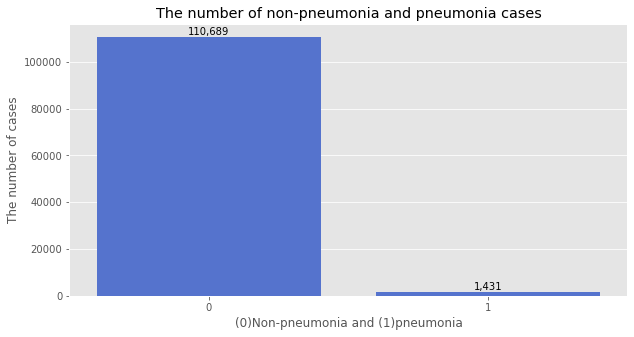

In [165]:
import warnings
warnings.filterwarnings('ignore')

# preparing cases table
cases = all_xray_df[['Image Index', 'Patient ID', 'Finding Labels']]
cases['Finding Labels'] =  cases['Finding Labels'].str.split('|')
all_labels = cases['Finding Labels'].explode().unique()
cases['Finding Labels'] = cases['Finding Labels'].map(set)
for label in all_labels:
    cases[label] = cases['Finding Labels'].map(lambda x: 1 if label in x else 0)
cases['Finding Labels'] = cases['Finding Labels'].map(list)
    
# plot the number of non-pneumonia and pneumonia cases  
pneumonia = cases[['Image Index', 'Pneumonia']]
pneumonia = pneumonia.groupby('Pneumonia')['Image Index'].nunique().reset_index()
fig, ax = plt.subplots(figsize=(10,5))    
sns.barplot(ax = ax, x= 'Pneumonia', y = 'Image Index',data= pneumonia, color = 'royalblue')
ax.set_title('The number of non-pneumonia and pneumonia cases')
ax.set(xlabel = '(0)Non-pneumonia and (1)pneumonia', ylabel= 'The number of cases')
for index, row in pneumonia.iterrows():
    text = f"""{row['Image Index']:,}"""
    ax.text(index, row['Image Index'] + 1000, text, color='black', ha="center")
plt.show()

In [172]:
cases

,Image Index,Patient ID,Finding Labels,Cardiomegaly,Emphysema,Effusion,No Finding,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation
0,00000001_000.png,1,[Cardiomegaly],1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,1,"[Cardiomegaly, Emphysema]",1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,00000001_002.png,1,"[Cardiomegaly, Effusion]",1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,2,[No Finding],0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,00000003_000.png,3,[Hernia],0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,30801,"[Pneumonia, Mass]",0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
112116,00030802_000.png,30802,[No Finding],0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
112117,00030803_000.png,30803,[No Finding],0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
112118,00030804_000.png,30804,[No Finding],0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


### The distribution of other diseases that are comorbid with pneumonia

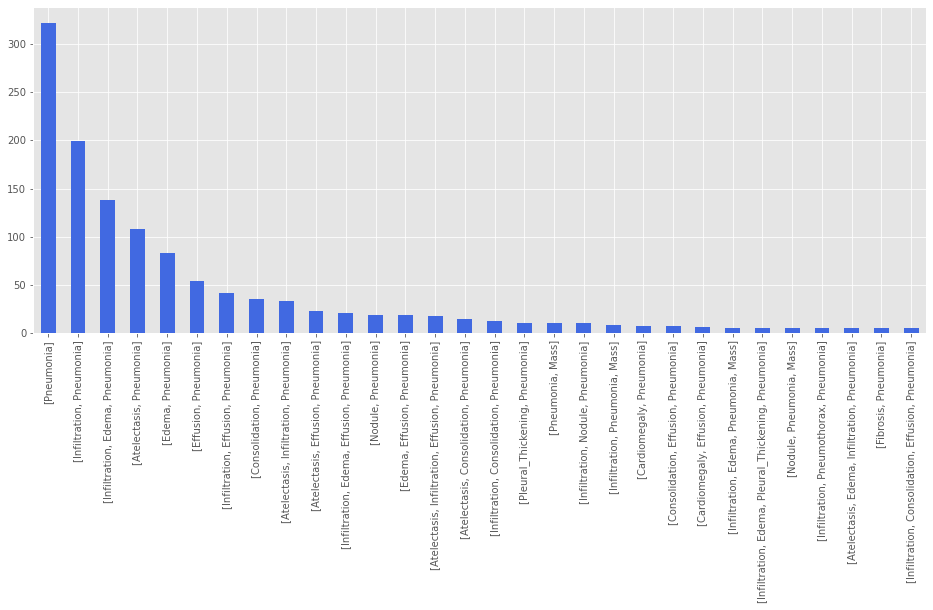

In [175]:
plt.figure(figsize=(16,6))
cases[cases.Pneumonia==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar', color = 'royalblue')
plt.show()

In [238]:
from scipy import sparse

print('We want to observe more info about other diseases that are comorbid with pneumonia as follows')
print('- Frequency of each label (The number of Image Index for each label)')
print('- Coocurance of pairs of Pneumonia with other labels')
print('- Similarity of pairs of Pneumonia with other labels based on Jaccard values')

# label frequency
label_freq = cases[['Image Index', 'Finding Labels']].explode('Finding Labels')
label_freq = label_freq[label_freq['Finding Labels'] != 'No Finding']
label_freq = label_freq.groupby('Finding Labels')['Image Index'].nunique().reset_index()
label_freq = label_freq.rename(columns = {'Image Index': 'label_freq'})
display(label_freq.sort_values('label_freq', ascending = False))

# comorbid_pneumonia
comorbid_pneumonia = cases.loc[cases.Pneumonia==1, ['Image Index', 'Finding Labels']].explode('Finding Labels')
comorbid_pneumonia = pd.merge(comorbid_pneumonia, comorbid_pneumonia, on = 'Image Index')
comorbid_pneumonia = comorbid_pneumonia.groupby(['Finding Labels_x', 'Finding Labels_y'])['Image Index'].nunique().reset_index()
jaccard_pneumonia = pd.merge(comorbid_pneumonia, label_freq, left_on = 'Finding Labels_x', right_on = 'Finding Labels').drop(columns = 'Finding Labels')
jaccard_pneumonia = pd.merge(jaccard_pneumonia, label_freq, left_on = 'Finding Labels_y', right_on = 'Finding Labels').drop(columns = 'Finding Labels')
jaccard_pneumonia['jaccard'] = jaccard_pneumonia['Image Index']/(jaccard_pneumonia['label_freq_x']+ jaccard_pneumonia['label_freq_y'] - jaccard_pneumonia['Image Index']) 
jaccard_pneumonia = jaccard_pneumonia.rename(columns = {'Image Index': 'cooccurrence',
                                                        'Finding Labels_x': 'interested_label',
                                                         'Finding Labels_y': 'cooccur_label'})
jaccard_pneumonia = jaccard_pneumonia[jaccard_pneumonia['interested_label'] == 'Pneumonia'].drop(columns = ['label_freq_x', 'label_freq_y'])
jaccard_pneumonia.sort_values('cooccurrence', ascending = False)

We want to observe more info about other diseases that are comorbid with pneumonia as follows
- Frequency of each label (The number of Image Index for each label)
- Coocurance of pairs of Pneumonia with other labels
- Similarity of pairs of Pneumonia with other labels based on Jaccard values


,Finding Labels,label_freq
8,Infiltration,19894
4,Effusion,13317
0,Atelectasis,11559
10,Nodule,6331
9,Mass,5782
13,Pneumothorax,5302
2,Consolidation,4667
11,Pleural_Thickening,3385
1,Cardiomegaly,2776
5,Emphysema,2516


,interested_label,cooccur_label,cooccurrence,jaccard
135,Pneumonia,Pneumonia,1431,1.000000
84,Pneumonia,Infiltration,605,0.029199
46,Pneumonia,Edema,340,0.100177
60,Pneumonia,Effusion,269,0.018579
10,Pneumonia,Atelectasis,262,0.020585
34,Pneumonia,Consolidation,123,0.020586
96,Pneumonia,Mass,71,0.009941
108,Pneumonia,Nodule,70,0.009100
121,Pneumonia,Pleural_Thickening,48,0.010067
21,Pneumonia,Cardiomegaly,41,0.009842


### Number of disease per patient

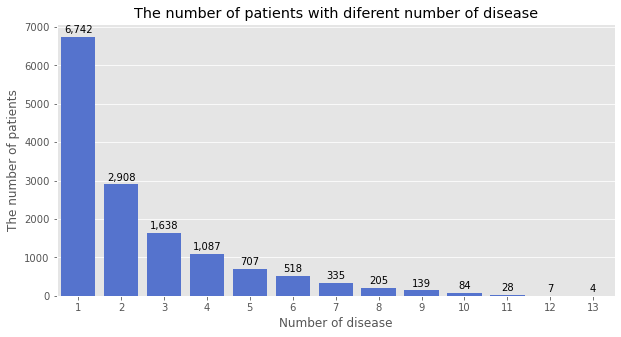

In [171]:
disease_per_patient = cases[['Patient ID', 'Finding Labels']].explode('Finding Labels')
disease_per_patient = disease_per_patient[disease_per_patient['Finding Labels'] != 'No Finding']
disease_per_patient = disease_per_patient.groupby('Patient ID')['Finding Labels'].nunique().reset_index()
disease_per_patient = disease_per_patient.groupby('Finding Labels')['Patient ID'].count().reset_index()

fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(ax = ax, x= 'Finding Labels', y = 'Patient ID',data= disease_per_patient, color = 'royalblue')
ax.set_title('The number of patients with diferent number of disease')
ax.set(xlabel = 'Number of disease', ylabel= 'The number of patients')
for index, row in disease_per_patient.iterrows():
    text = f"""{row['Patient ID']:,}"""
    ax.text(index, row['Patient ID'] + 100, text, color='black', ha="center")
plt.show()

### Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

In [ ]:
#plt.figure(figsize=(5,5))
#plt.hist(dcm.pixel_array.ravel(), bins = 256)